In [34]:
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [35]:
df_merged = pd.read_csv('merged.csv', index_col=0)

In [36]:
df_merged.head()

latitude  longitude        room_type  price  minimum_nights  \
0 -22.96592  -43.17896  Entire home/apt    191               7   
1 -22.98467  -43.19611  Entire home/apt    424               5   
2 -22.97712  -43.19045  Entire home/apt    159               7   
3 -22.98302  -43.21427  Entire home/apt    344               2   
4 -22.98816  -43.19359  Entire home/apt    482               2   

   number_of_reviews  reviews_per_month  calculated_host_listings_count  \
0                251               2.08                               1   
1                 94               1.22                               1   
2                238               1.95                               3   
3                282               2.33                               1   
4                181               2.23                               1   

   availability_365  literate  pop_total  age_proportion  \
0               287     99.07   147021.0        0.458506   
1                93     99.27    46808.0        0.481542   
2               154     99.07   147021.0        0.458506   
3                 0     99.27    46808.0        0.481542   
4               170     99.27    46808.0        0.481542   

   last_review_days_ago name_lan  
0                 295.0    other  
1                 310.0    other  
2                 346.0    other  
3                 330.0    other  
4                 317.0    other

In [37]:
df_merged['price'].describe()

count     35485.000000
mean        787.669381
std        2390.660908
min           0.000000
25%         159.000000
50%         300.000000
75%         642.000000
max      132358.000000
Name: price, dtype: float64

In [38]:
q = df_merged['price'].quantile(q=0.9)
print('Showing only data with price < R$ %d,00'%q)

px.scatter_mapbox(
    df_merged[df_merged['price']<q], 
    lat='latitude', 
    lon='longitude', 
    color='price', 
    mapbox_style="stamen-terrain")

Showing only data with price < R$ 1498,00


In [39]:
df_merged = df_merged.drop([ 
                            'latitude',
                            'longitude',
                           ], axis=1)

In [40]:
from scipy.stats import kruskal

In [41]:
#non parametric; difference in median of several groups
s, p = kruskal(df_merged[df_merged['room_type']=='Entire home/apt']['price'],
               df_merged[df_merged['room_type']=='Hotel room']['price'],
               df_merged[df_merged['room_type']=='Private room']['price'],
               df_merged[df_merged['room_type']=='Shared room']['price'])
print ('p value:', p)
if p<0.05: print ("(Significant)")
else: print ("(Not significant)")
    
df_merged[['price', 'room_type']].groupby('room_type').median()

p value: 0.0
(Significant)


price
room_type             
Entire home/apt    391
Hotel room         185
Private room       150
Shared room        101

In [42]:
s, p = kruskal(df_merged[df_merged['name_lan']=='other']['price'],
               df_merged[df_merged['name_lan']=='por']['price'])
print ('p value:', p)
if p<0.05: print ("(Significant)")
else: print ("(Not significant)")
    
df_merged[['price', 'name_lan']].groupby('name_lan').median()

p value: 6.161193250908658e-135
(Significant)


price
name_lan       
other       328
por         252

# Linear correlation

In [43]:
corr = df_merged.corr(method='spearman')
corr['price_abs'] = corr['price'].abs()
corr = corr.sort_values(by='price_abs', ascending=False)
corr = corr['price'][1:]
print('Spearman correlation')
corr

Spearman correlation


reviews_per_month                -0.380002
number_of_reviews                -0.366709
last_review_days_ago             -0.257248
minimum_nights                    0.179453
literate                          0.165524
calculated_host_listings_count   -0.087265
age_proportion                    0.041635
availability_365                 -0.021811
pop_total                        -0.009059
Name: price, dtype: float64

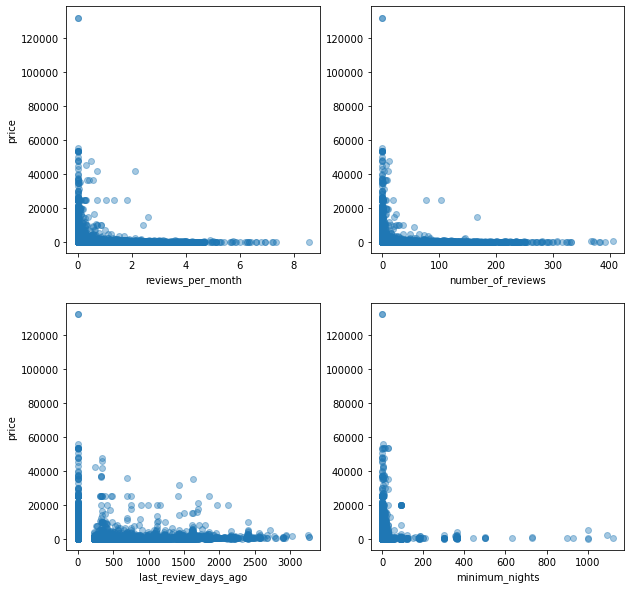

In [44]:
plt.subplots(2,2, figsize=(10,10))
for k in range(0, 4):
    plt.subplot(2,2,k+1)
    plt.scatter(df_merged[corr.index[k]], df_merged['price'], alpha=0.4)
    plt.xlabel(corr.index[k])
    if not k%2: plt.ylabel('price')

Text(0.5, 1.0, 'age_proportion')

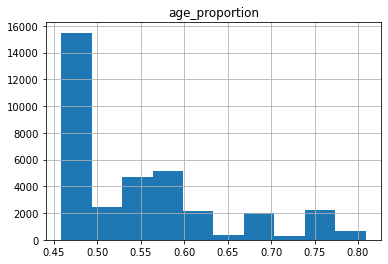

In [45]:
df_merged['age_proportion'].hist()
plt.title('age_proportion')

Text(0.5, 1.0, 'literate')

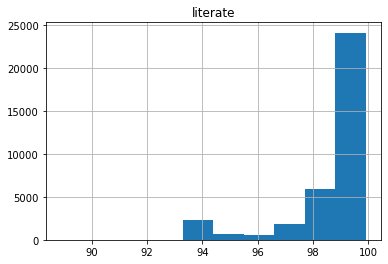

In [46]:
df_merged['literate'].hist()
plt.title('literate')

<AxesSubplot:title={'center':'price'}>

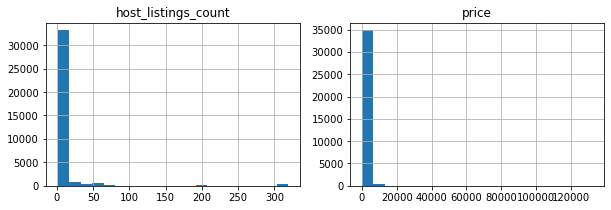

In [47]:
plt.subplots(1, 2, figsize=(10, 3))
plt.subplot(121)
plt.title('host_listings_count')
df_merged['calculated_host_listings_count'].hist(bins=20)

plt.subplot(122)
plt.title('price')
df_merged['price'].hist(bins=20)

Tests whether two samples have a monotonic relationship.

Assumptions

    Observations in each sample are independent and identically distributed (iid).
    Observations in each sample can be ranked.

Interpretation

    H0: the two samples are independent.
    H1: there is a dependency between the samples.

Source: https://machinelearningmastery.com/statistical-hypothesis-tests-in-python-cheat-sheet/

In [48]:
from scipy.stats import spearmanr
stat, p = spearmanr(df_merged['calculated_host_listings_count'], df_merged['price'])
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
	print('Probably independent')
else:
	print('Probably dependent')

stat=-0.087, p=0.000
Probably dependent


# Importance analysis

In [49]:
import sklearn.metrics as metrics
import math
from sklearn.ensemble import RandomForestRegressor

In [50]:
# Preprocessing room type
temp = pd.get_dummies(df_merged['room_type'], prefix='room_type', prefix_sep=' ')
df_merged = pd.concat([df_merged, temp], axis=1)
df_merged = df_merged.drop(['room_type'], axis=1)

# Preprocessing language
df_merged['name_lan_int'] = df_merged['name_lan'].apply(lambda x: 1 if x=='por' else 0)
df_merged = df_merged.drop(['name_lan'], axis=1)
df_merged = df_merged.dropna()

df_merged.to_csv('merged_ML.csv')

# Separing target variable
X = df_merged.drop('price', axis=1)
y = df_merged ['price']

In [53]:
df_merged

price  minimum_nights  number_of_reviews  reviews_per_month  \
0        191               7                251               2.08   
1        424               5                 94               1.22   
2        159               7                238               1.95   
3        344               2                282               2.33   
4        482               2                181               2.23   
...      ...             ...                ...                ...   
35726    349               3                  0               0.00   
35727     59               2                  0               0.00   
35728    145               1                  0               0.00   
35729    244               2                  0               0.00   
35730    392               3                  0               0.00   

       calculated_host_listings_count  availability_365  literate  pop_total  \
0                                   1               287     99.07   147021.0   
1                                   1                93     99.27    46808.0   
2                                   3               154     99.07   147021.0   
3                                   1                 0     99.27    46808.0   
4                                   1               170     99.27    46808.0   
...                               ...               ...       ...        ...   
35726                              14               364     99.07   147021.0   
35727                               2                84     99.27    46808.0   
35728                               4               365     99.07   147021.0   
35729                              24               364     99.07   147021.0   
35730                              50               364     99.27    46808.0   

       age_proportion  last_review_days_ago  room_type Entire home/apt  \
0            0.458506                 295.0                          1   
1            0.481542                 310.0                          1   
2            0.458506                 346.0                          1   
3            0.481542                 330.0                          1   
4            0.481542                 317.0                          1   
...               ...                   ...                        ...   
35726        0.458506                   0.0                          1   
35727        0.481542                   0.0                          0   
35728        0.458506                   0.0                          0   
35729        0.458506                   0.0                          1   
35730        0.481542                   0.0                          1   

       room_type Hotel room  room_type Private room  room_type Shared room  \
0                         0                       0                      0   
1                         0                       0                      0   
2                         0                       0                      0   
3                         0                       0                      0   
4                         0                       0                      0   
...                     ...                     ...                    ...   
35726                     0                       0                      0   
35727                     0                       1                      0   
35728                     0                       1                      0   
35729                     0                       0                      0   
35730                     0                       0                      0   

       name_lan_int  
0                 0  
1                 0  
2                 0  
3                 0  
4                 0  
...             ...  
35726             1  
35727             1  
35728             0  
35729             0  
35730             1  

[35485 rows x 15 columns]

In [51]:
# Train model
model = RandomForestRegressor(max_depth=15, n_estimators=100)
model.fit(X,y)

print ("Feature Importance")
_imp = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)
_imp

Feature Importance


calculated_host_listings_count    0.282523
availability_365                  0.206356
minimum_nights                    0.099057
pop_total                         0.078986
literate                          0.070970
age_proportion                    0.068784
reviews_per_month                 0.062511
last_review_days_ago              0.046386
name_lan_int                      0.034456
number_of_reviews                 0.025001
room_type Entire home/apt         0.018320
room_type Private room            0.002941
room_type Shared room             0.002637
room_type Hotel room              0.001070
dtype: float64

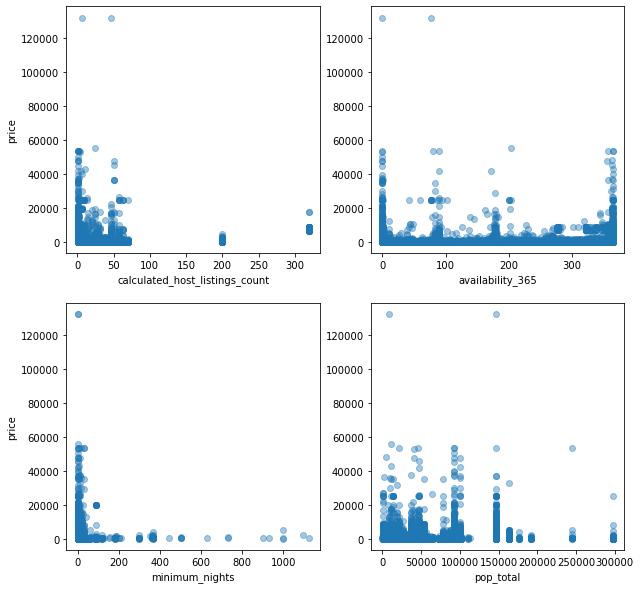

In [52]:
plt.subplots(2,2, figsize=(10,10))
for k in range(0, 4):
    plt.subplot(2,2,k+1)
    plt.scatter(df_merged[_imp.index[k]], df_merged['price'], alpha=0.4)
    plt.xlabel(_imp.index[k])
    if not k%2: plt.ylabel('price')